In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('data.csv',delimiter=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:


df = df[['age', 'ap_hi','cardio']]
df['age'] = round(df['age'] / 365)
df = df.head(5)
df

<ipython-input-4-d2ee7fff3c99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = round(df['age'] / 365)


,age,ap_hi,cardio
0,50.0,110,0
1,55.0,140,1
2,52.0,130,1
3,48.0,150,1
4,48.0,100,0


In [5]:
X = df[['age', 'ap_hi']]
y = df['cardio']

In [6]:
from sklearn.tree import DecisionTreeClassifier


tree = DecisionTreeClassifier(random_state=1)
tree.fit(X, y)

DecisionTreeClassifier(random_state=1)

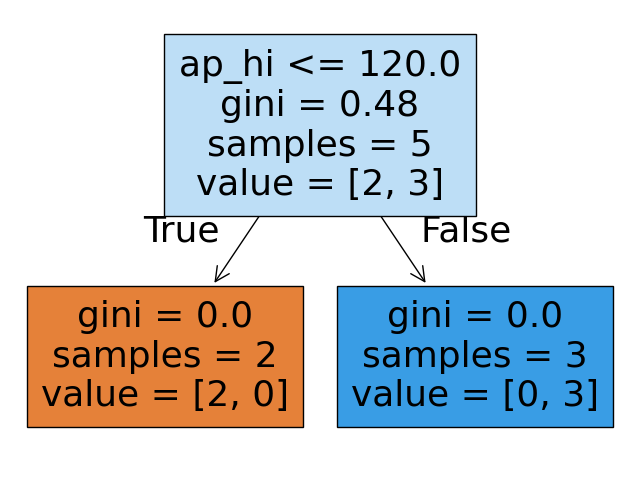

In [7]:
from sklearn.tree import plot_tree


plt.figure(figsize=(8, 6))
plot_tree(tree, feature_names=['age', 'ap_hi'], filled=True);

Tree model's for the classification task use two main informativeness criteria for error counting, which operate on the probabilities of occurrence of each class:


$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

**Informativeness criteria** for the classification task:
- _Entropic criterion_ or Shannon's _entropy_ :

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$


- _Gini criterion_ or _Gini index_:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$



#criterion - entropy

In [8]:
df

,age,ap_hi,cardio
0,50.0,110,0
1,55.0,140,1
2,52.0,130,1
3,48.0,150,1
4,48.0,100,0


In [9]:
class_0 = 2
class_1 = 3
total = class_0 + class_1

p_0 = class_0 / total
p_1 = class_1 / total
p_0, p_1

(0.4, 0.6)

$$p_0 = \frac{2}{5} = 0.4$$

$$p_1 = \frac{3}{5} = 0.6$$

In [12]:
entropy_start = - (p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
entropy_start

0.9709505944546686

It turns out to be rather high (recall that ideally the entropy criterion of informativity should tend to zero), which means that since the entropy is high, there is no certainty yet.

In [13]:
results = pd.DataFrame(columns=['feature', 'value', 'IG'])
results

,feature,value,IG


#age <= 50

In [14]:
condition = df['age'] <= 50
display(df[condition], df[~condition])

,age,ap_hi,cardio
0,50.0,110,0
3,48.0,150,1
4,48.0,100,0


,age,ap_hi,cardio
1,55.0,140,1
2,52.0,130,1


In [15]:
class_0 = 2
class_1 = 1
total = class_0 + class_1

p_0 = class_0 / total
p_1 = class_1 / total
p_0, p_1

(0.6666666666666666, 0.3333333333333333)

$$p_0 = \frac{2}{3} = 0.667$$

$$p_1 = \frac{1}{3} = 0.334$$

In [16]:
entropy_left = - (p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
entropy_left

0.9182958340544896

In [17]:
class_0 = 0
class_1 = 2
total = class_0 + class_1

p_0 = class_0 / total
p_1 = class_1 / total
p_0, p_1

(0.0, 1.0)

$$p_0 = \frac{0}{2} = 0$$

$$p_1 = \frac{2}{2} = 1$$

In [18]:
entropy_right = - p_1 * np.log2(p_1)
entropy_right

-0.0

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$$


In [19]:
IG = entropy_start - (3/5) * entropy_left - (2/5) * entropy_right
IG

0.4199730940219749

In [21]:
# Create a new row as a DataFrame
new_row = pd.DataFrame([{'feature': 'age', 'value': 50, 'IG': IG}])

# Concatenate the new row with the results DataFrame
results = pd.concat([results, new_row], ignore_index=True)
#results.loc[len(results)] = ['age', 50, IG]
display(results)

<ipython-input-21-08c0e5fbca67>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


,feature,value,IG
0,age,50,0.419973


Enough with counting informativeness criteria and information gain by hand, let's make two auxiliary functions to count entropy and information gain.

In [23]:


def entropy(labels):
    """
    input labels - target values
    output is the calculated entropy
    """
    labels = list(labels)

    #  counting the number of objects of different classes
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    # calculate criterion
    ent = 0
    for label in classes:
        p = classes[label] / len(labels)
        ent += p * np.log2(p)

    return -ent

In [24]:

def info_gain(left_labels, right_labels, root_labels):

    #fraction of the sample that went to the left subtree
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    IG = entropy(root_labels) - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

    return IG

In [25]:
IG = info_gain(df[condition]['cardio'], df[~condition]['cardio'], df['cardio'])
IG

0.4199730940219749

Age <= 52

In [27]:
condition = df['age'] <= 52
display(df[condition], df[~condition])

,age,ap_hi,cardio
0,50.0,110,0
2,52.0,130,1
3,48.0,150,1
4,48.0,100,0


,age,ap_hi,cardio
1,55.0,140,1


In [28]:
IG = info_gain(df[condition]['cardio'], df[~condition]['cardio'], df['cardio'])
IG

0.17095059445466854

In [29]:
results.loc[len(results)] = ['age', 52, IG]
display(results)

,feature,value,IG
0,age,50,0.419973
1,age,52,0.170951


#Age <= 48

In [30]:
condition = df['age'] <= 52
display(df[condition], df[~condition])

,age,ap_hi,cardio
0,50.0,110,0
2,52.0,130,1
3,48.0,150,1
4,48.0,100,0


,age,ap_hi,cardio
1,55.0,140,1


In [31]:
IG = info_gain(df[condition]['cardio'], df[~condition]['cardio'], df['cardio'])
IG

0.17095059445466854

In [32]:
results.loc[len(results)] = ['age', 52, IG]
display(results)

,feature,value,IG
0,age,50,0.419973
1,age,52,0.170951
2,age,52,0.170951


Age <= 55

In [35]:
condition = df['age'] <= 55
display(df[condition], df[~condition])

,age,ap_hi,cardio
0,50.0,110,0
1,55.0,140,1
2,52.0,130,1
3,48.0,150,1
4,48.0,100,0


,age,ap_hi,cardio


In [36]:
IG = info_gain(df[condition]['cardio'], df[~condition]['cardio'], df['cardio'])
IG

0.0

In [41]:
import pandas as pd

# Create the specified DataFrame
data = {
    'feature': ['age', 'age', 'age', 'age', 'ap_hi', 'ap_hi', 'ap_hi', 'ap_hi'],
    'value': [50, 50, 52, 48, 110, 100, 140, 130],
    'IG': [0.419973, 0.419973, 0.170951, 0.019973, 0.970951, 0.321928, 0.170951, 0.419973]
}

# Convert dictionary to DataFrame
results_df = pd.DataFrame(data)
results_df


,feature,value,IG
0,age,50,0.419973
1,age,50,0.419973
2,age,52,0.170951
3,age,48,0.019973
4,ap_hi,110,0.970951
5,ap_hi,100,0.321928
6,ap_hi,140,0.170951
7,ap_hi,130,0.419973


This question ap_hi <= 110 - it has the maximum information gain out of all the different questions we asked. So we will use it for our decision tree.

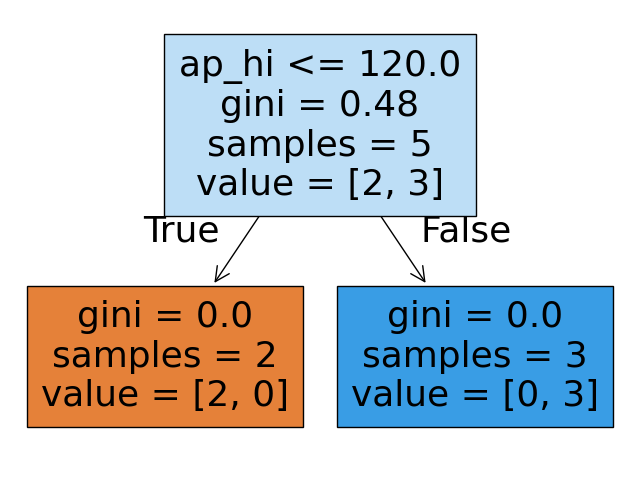

In [40]:

plt.figure(figsize=(8, 6))
plot_tree(tree, feature_names=['age', 'ap_hi'], filled=True);

In [37]:
sorted(df['ap_hi'].unique())

[100, 110, 130, 140, 150]

In [38]:
display(
    f'ap_hi <= {(100 + 110) / 2}',
    f'ap_hi <= {(110 + 130) / 2}',
    f'ap_hi <= {(130 + 140) / 2}',
    f'ap_hi <= {(140 + 150) / 2}',
)

'ap_hi <= 105.0'

'ap_hi <= 120.0'

'ap_hi <= 135.0'

'ap_hi <= 145.0'

In this case, we will get the same breakdowns as for our questions, for example, a question using this methodology ap_hi <= 105 (average between 100 and 110).

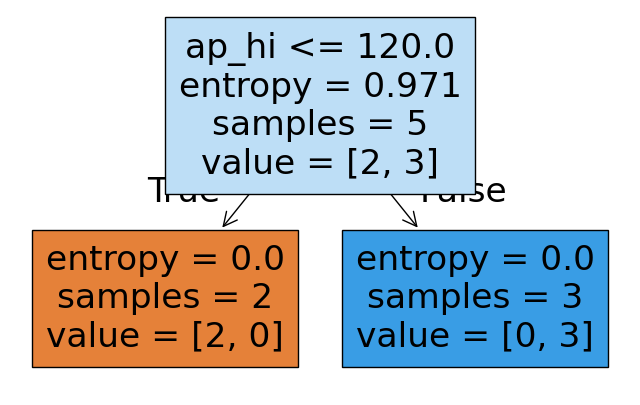

In [44]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X, y)

plt.figure(figsize=(8, 5))
plot_tree(tree, feature_names=['age', 'ap_hi'], filled=True);

In [52]:
df = pd.read_csv('data.csv',delimiter=';')
X = df[['age', 'ap_hi']].iloc[:10]
y = df['cardio'].iloc[:10]

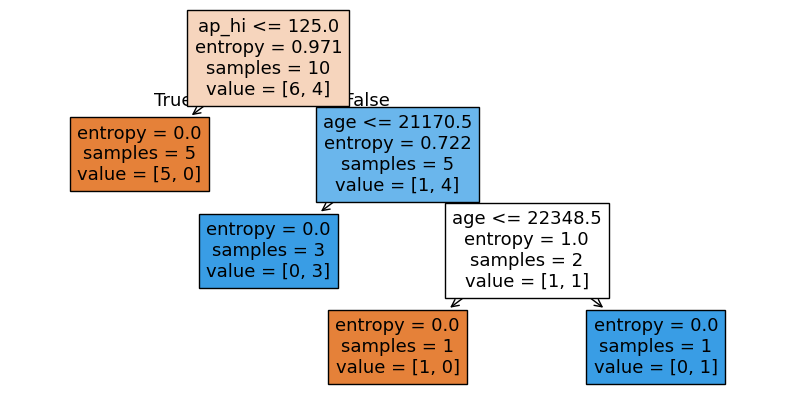

In [53]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X, y)

plt.figure(figsize=(10, 5))
plot_tree(tree, feature_names=['age', 'ap_hi'], filled=True);

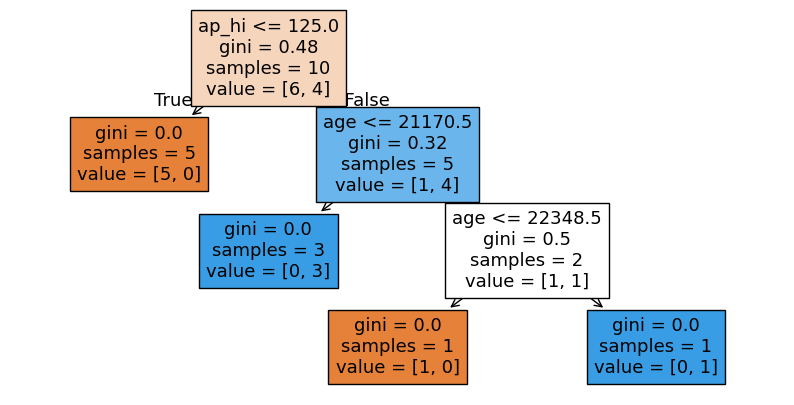

In [54]:
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(X, y)

plt.figure(figsize=(10, 5))
plot_tree(tree, feature_names=['age', 'ap_hi'], filled=True);